In [266]:
from collections import Counter

from pyparsing import WordStart
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import requests
from io import StringIO
import math
import gensim.downloader as api
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import Word2Vec

class PreprocessData:
    def __init__(self,path,lang='english'): 
        self.dataset=pd.read_csv(path, sep=",")
        self.dataset=self.dataset[["content","score"]]
        self.stopwords=stopwords.words(lang)
        self.preprocess()
    
    @staticmethod
    def remove_punctuation(text):
        '''a function for removing punctuation'''
        # replacing the punctuations with no space, 
        # which in effect deletes the punctuation marks 
        translator = str.maketrans('', '', string.punctuation)
        # return the text stripped of punctuation marks
        return text.translate(translator)

    #A function to remove the stopwords
    def remove_stopwords(self,text):
        text = [word.lower() for word in text.split() if word.lower() not in self.stopwords]
        # joining the list of words with space separator
        return " ".join(text)

    def preprocess(self):
        self.dataset.iloc[:,0] = self.dataset.iloc[:,0].apply(self.remove_punctuation)
        self.dataset.iloc[:,0] = self.dataset.iloc[:,0].apply(self.remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [267]:
# from google.colab import drive
# drive.mount('/content/drive')

In [268]:
path="/content/reviews.csv"
dataset=PreprocessData(path)

In [269]:
dataset.dataset.head()

,content,score
0,cannot open app anymore,1
1,begging refund app month nobody replying,1
2,costly premium version approx indian rupees 91...,1
3,used keep organized 2020 updates made mess thi...,1
4,dan birthday oct 28,1


In [270]:
# wv = api.load('glove-wiki-gigaword-50')

In [271]:
# from gensim.scripts.glove2word2vec import glove2word2vec

In [272]:
# import gensim.models

# # This should take approximately 3 minutes
# model = gensim.models.Word2Vec(sentences=sentences,min_count=1)

In [273]:
# print(list(model.wv.vocab))

In [274]:
class WordRepresentation:
    def __init__(self,dataset):
        self.dataset=dataset
        self.glove={}
        self.word2vec={}
        self.compute_glove()
        self.compute_word2vec()
        self.w2v_final_data=[]
        self.glo_final_data=[]
        self.represent_all_sentences()
    
    #Compute Glove
    def compute_glove(self):
      wv = api.load('glove-wiki-gigaword-50')
      #self.glove["nan"]=(np.zeros(50,),0)
      #word_index=1
      for i in range(len(self.dataset)):
        document=self.dataset.iloc[i,0]
        word_list=document.split(" ")
        for word in word_list:
          if word in wv.vocab:
            self.glove[word]=wv.word_vec(word)
            # self.glove[word]=(wv.word_vec(word),word_index)
            # word_index+=1
    
    @staticmethod
    def tokenize(data): 
      word = []
      for i in range(len(data)):
        new_doc = data[i].split()
        word.append(new_doc)
      return word
    
    def compute_word2vec(self):
      token = WordRepresentation.tokenize(dataset.dataset['content'])
      model = Word2Vec(sentences=token, workers = 1, size = 50, min_count = 1, window = 3)
      # self.word2vec["nan"]=(np.zeros(50,),0)
      # word_index=1
      for i in range(len(self.dataset)):
        document=self.dataset.iloc[i,0]
        word_list=document.split(" ")
        for word in word_list:
          if word in model.wv.vocab:
            self.word2vec[word]=model.wv.word_vec(word)
            # self.word2vec[word]=(model.wv.word_vec(word),word_index)
            # word_index+=1
    
    def sentence_representation(self,sentence,method="word2vec",sentence_length=20,vector_length=50):
      the_sentence=sentence.split(' ')
      if method=="word2vec"or method=="glove":
        if method=="word2vec":
          words_dict=self.word2vec
        else:
          words_dict=self.glove
        
        matrix=np.zeros((sentence_length,vector_length))
        i =0
        for word in the_sentence:
          if word in words_dict:
            matrix[i]=words_dict[word]
            i+=1
          if i>=sentence_length:
            break
        return matrix
    
    # def represent_all_sentences(self,sentence_length=20,vector_length=50):
    #   for i in range(len(self.dataset)):
    #     document=self.dataset.iloc[i,0]
    #     y=self.dataset.iloc[i,1]
    #     x_w2v=self.sentence_representation(document,sentence_length=sentence_length,vector_length=vector_length)
    #     x_glo=self.sentence_representation(document,method="glove",sentence_length=sentence_length,vector_length=vector_length)
    #     self.w2v_final_data.append((x_w2v,y))
    #     self.glo_final_data.append((x_glo,y))
        
    def represent_all_sentences(self,sentence_length=20,vector_length=50):
      for i in range(len(self.dataset)):
        document=self.dataset.iloc[i,0]
        y=torch.tensor([self.dataset.iloc[i,1]])
        x_w2v=self.sentence_representation(document,sentence_length=sentence_length,vector_length=vector_length)
        y_w2v=torch.tensor(x_w2v.reshape(1,-1))
        y_w2v=y_w2v.float()
        x_glo=self.sentence_representation(document,method="glove",sentence_length=sentence_length,vector_length=vector_length)
        y_glo=torch.tensor(x_glo.reshape(1,-1))
        y_glo=y_glo.float()
        self.w2v_final_data.append((y_w2v,y))
        self.glo_final_data.append((y_glo,y))


In [545]:
new_data=WordRepresentation(dataset.dataset.iloc[:10000])

In [470]:
# new_data.represent_all_sentences()

In [471]:
# new_data.glo_final_data[0]

In [472]:
# new_data.glove

In [473]:
# new_data.word2vec

In [474]:
len(new_data.word2vec)

12484

In [475]:
len(new_data.glove)

8482

In [476]:
input_size=len(new_data.glove)*20

In [477]:
vector_lenght=50
sentence_lenght=20
input_dim=vector_lenght*sentence_lenght
num_classes=5

In [478]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [479]:
device

'cuda:0'

In [518]:
class FcNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(FcNeuralNet, self).__init__()
        self.fc1= nn.Linear(input_dim, hidden_dim)
        self.fc2= nn.Linear(hidden_dim, hidden_dim*2)
        # self.fc3= nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4= nn.Linear(hidden_dim*2, num_classes)

    
    def forward(self, x):
      """
      The forward pass of the fully connected layer
      """
      x = F.tanh(self.fc1(x))
      x=self.fc2(x)
      # x=F.tanh(self.fc3(x))
      x=F.tanh(self.fc4(x))

      out=F.log_softmax(x, dim =1)
      return out

In [519]:
# s,l=get_batch(glove_train,4,32)
# s

In [520]:
# x=new_data.glo_final_data[3]

In [521]:
# model_glove(s[0])

In [522]:
model_glove=FcNeuralNet(20*50,100,5)
model_w2vec=FcNeuralNet(20*50,100,5)

In [523]:
criterion = nn.CrossEntropyLoss()
optimizer_w2vec = torch.optim.SGD(model_w2vec.parameters(), lr= 0.0001)
optimizer_glove = torch.optim.SGD(model_glove.parameters(), lr= 0.0001)

### Split for glove

In [524]:
from sklearn.model_selection import train_test_split
glove_train, glove_test = train_test_split(new_data.glo_final_data, test_size = 0.2, random_state = 42, shuffle = True)

### Split for word2vec

In [525]:
from sklearn.model_selection import train_test_split
w2v_train, w2v_test = train_test_split(new_data.w2v_final_data, test_size = 0.2, random_state = 42, shuffle = True)

In [526]:
gl_size=len(glove_train)

In [527]:
len(w2v_train)

8000

In [528]:
num_epochs = 100

In [529]:
# l=glove_train[4:36]

In [530]:
# l[-1][0]

In [536]:
all=get_batch(glove_train,0,len(glove_train))

In [542]:
dict_classes={"1":0,"2":0,"3":0,"4":0,"5":0}
for val in all[1]:
  c=str(int(val.item()))
  dict_classes[c]+=1
print(dict_classes)

{'1': 1666, '2': 1517, '3': 1236, '4': 1745, '5': 1836}


In [531]:
def get_batch(data,index,batch_size):
  size=batch_size
  length=len(data)
  input_length=len(data[0][0])
  if index+batch_size>length:
    size=length-index
  sentences=[]
  labels=torch.zeros((size,1))
  batch_data=data[index:index+size]
  for i in range(len(batch_data)):

    sentence,label=batch_data[i]
    #print("s",label.shape)
    sentences.append(sentence)
    labels[i]=label
  
  return torch.stack(sentences),labels

In [532]:
# s,l=get_batch(glove_train,4,32)
# l

In [533]:
# s

### Train for Glove

In [534]:
glosses = []
for epoch in range(num_epochs):
  model_glove.train()
  running_loss = 0.0
  for i in glove_train:
    sentences, labels = i

    # Move tensors to the configured device
    # sentences = sentences.to(device)
    # labels = labels.to(device)
        
    # Forward pass
    outputs = model_glove(sentences)
    glove_loss = criterion(outputs, labels-1)    
    # Backprpagation and optimization
    glove_loss.backward()
    optimizer_glove.step()
    optimizer_glove.zero_grad()
    
    running_loss += glove_loss.item() 
            
  loss_values = (running_loss / len(glove_train))
  glosses.append(loss_values)
        
  print("=" * 25)
  print('| Epoch {:3d}| Loss: {:.4f}'.format(epoch+1,glove_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


| Epoch   1| Loss: 1.6752
| Epoch   2| Loss: 1.7271
| Epoch   3| Loss: 1.7339
| Epoch   4| Loss: 1.7271
| Epoch   5| Loss: 1.7189
| Epoch   6| Loss: 1.7124
| Epoch   7| Loss: 1.7066
| Epoch   8| Loss: 1.6998
| Epoch   9| Loss: 1.6913
| Epoch  10| Loss: 1.6816
| Epoch  11| Loss: 1.6713
| Epoch  12| Loss: 1.6615
| Epoch  13| Loss: 1.6525
| Epoch  14| Loss: 1.6445
| Epoch  15| Loss: 1.6372
| Epoch  16| Loss: 1.6303
| Epoch  17| Loss: 1.6233
| Epoch  18| Loss: 1.6160
| Epoch  19| Loss: 1.6080
| Epoch  20| Loss: 1.5992
| Epoch  21| Loss: 1.5893
| Epoch  22| Loss: 1.5784
| Epoch  23| Loss: 1.5665
| Epoch  24| Loss: 1.5535
| Epoch  25| Loss: 1.5396
| Epoch  26| Loss: 1.5248
| Epoch  27| Loss: 1.5092
| Epoch  28| Loss: 1.4930
| Epoch  29| Loss: 1.4762
| Epoch  30| Loss: 1.4590
| Epoch  31| Loss: 1.4414
| Epoch  32| Loss: 1.4237
| Epoch  33| Loss: 1.4058
| Epoch  34| Loss: 1.3880
| Epoch  35| Loss: 1.3703
| Epoch  36| Loss: 1.3527
| Epoch  37| Loss: 1.3355
| Epoch  38| Loss: 1.3186
| Epoch  39|

### train for word2vec

In [449]:
wlosses = []
for epoch in range(num_epochs):
  model_w2vec.train()
  running_loss = 0.0
  for i in w2v_train:
    sentences, labels = i

    # Move tensors to the configured device
    # sentences = sentences.to(device)
    # labels = labels.to(device)
        
    # Forward pass
    outputs = model_w2vec(sentences)
    w2vec_loss = criterion(outputs, labels-1)    
    # Backprpagation and optimization
    w2vec_loss.backward()
    optimizer_w2vec.step()
    optimizer_w2vec.zero_grad()

    running_loss += w2vec_loss.item()
            
  loss_values = (running_loss / len(w2v_train))
  wlosses.append(loss_values)    
  print("=" * 25)
  print('| Epoch {:3d}| Loss: {:.4f}'.format(epoch+1,w2vec_loss.item()))  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


| Epoch   1| Loss: 1.4809
| Epoch   2| Loss: 1.4856
| Epoch   3| Loss: 1.4865
| Epoch   4| Loss: 1.4839
| Epoch   5| Loss: 1.4782
| Epoch   6| Loss: 1.4699
| Epoch   7| Loss: 1.4592
| Epoch   8| Loss: 1.4465
| Epoch   9| Loss: 1.4323
| Epoch  10| Loss: 1.4167
| Epoch  11| Loss: 1.4002
| Epoch  12| Loss: 1.3831
| Epoch  13| Loss: 1.3656
| Epoch  14| Loss: 1.3480
| Epoch  15| Loss: 1.3306
| Epoch  16| Loss: 1.3137
| Epoch  17| Loss: 1.2975
| Epoch  18| Loss: 1.2821
| Epoch  19| Loss: 1.2677
| Epoch  20| Loss: 1.2543
| Epoch  21| Loss: 1.2419
| Epoch  22| Loss: 1.2306
| Epoch  23| Loss: 1.2202
| Epoch  24| Loss: 1.2108
| Epoch  25| Loss: 1.2023
| Epoch  26| Loss: 1.1945
| Epoch  27| Loss: 1.1875
| Epoch  28| Loss: 1.1813
| Epoch  29| Loss: 1.1757
| Epoch  30| Loss: 1.1707
| Epoch  31| Loss: 1.1665
| Epoch  32| Loss: 1.1628
| Epoch  33| Loss: 1.1599
| Epoch  34| Loss: 1.1576
| Epoch  35| Loss: 1.1560
| Epoch  36| Loss: 1.1551
| Epoch  37| Loss: 1.1549
| Epoch  38| Loss: 1.1554
| Epoch  39|

## Predict

### for glove

In [544]:
with torch.no_grad():
    model_glove.eval()
    correct = 0
    total = 0
    for i in glove_test:
      sentences, labels = i
      outputs = model_glove(sentences)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted+1 == labels).sum().item()
      print(predicted,labels)
    
print("="* 33)
print('Accuracy test: {:.2f} %'.format(100 * correct / total))
print("="* 33)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([4]) tensor([5])
tensor([4]) tensor([5])
tensor([2]) tensor([5])
tensor([4]) tensor([5])
tensor([3]) tensor([4])
tensor([0]) tensor([1])
tensor([0]) tensor([4])
tensor([2]) tensor([3])
tensor([1]) tensor([1])
tensor([4]) tensor([3])
tensor([4]) tensor([5])
tensor([4]) tensor([4])
tensor([0]) tensor([3])
tensor([4]) tensor([5])
tensor([0]) tensor([1])
tensor([4]) tensor([4])
tensor([0]) tensor([4])
tensor([0]) tensor([1])
tensor([0]) tensor([2])
tensor([3]) tensor([3])
tensor([0]) tensor([1])
tensor([0]) tensor([2])
tensor([4]) tensor([5])
tensor([4]) tensor([5])
tensor([0]) tensor([1])
tensor([1]) tensor([1])
tensor([0]) tensor([1])
tensor([1]) tensor([3])
tensor([3]) tensor([4])
tensor([3]) tensor([2])
tensor([0]) tensor([2])
tensor([4]) tensor([5])
tensor([4]) tensor([5])
tensor([1]) tensor([1])
tensor([4]) tensor([4])
tensor([0]) tensor([3])
tensor([4]) tensor([5])
tensor([1]) tensor([2])
tensor([1]) tensor([1])
tensor([4]) tensor([5])
tensor([4]) tensor([5])
tensor([0]) tens

### for word2vec

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for i in w2v_test:
    sentences, labels = i

    outputs = model_w2vec(sentences)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    if 
    correct += (predicted+1 == labels).sum().item()
    print(predicted,labels)
    
print("="* 33)
print('Accuracy test : {:.2f} %'.format(100 * correct / total))
print("="* 33)

## Visualisation

In [66]:
glosses

[1.3884795013442635,
 1.3743059265365203,
 1.3631441714117924,
 1.3532171027362347,
 1.343942249243458,
 1.3351697883134086,
 1.3267705478395024,
 1.3186445288732649,
 1.3107348558555048,
 1.3030051984637976,
 1.2954263878737886,
 1.2879617669309178,
 1.280584249223272,
 1.2732794410735369,
 1.266044500855108,
 1.2588490492353837,
 1.2517028200502196,
 1.2445862002546588,
 1.2374588627989094,
 1.2303655223920942,
 1.223245419971645,
 1.2161180048498015,
 1.2089737433878085,
 1.2017979399673642,
 1.1945903188362719,
 1.1873318547507128,
 1.1800287362746895,
 1.1726946938969194,
 1.1653181020667156,
 1.157871785586079]

In [58]:
import matplotlib.pyplot as plt

In [71]:
def plot(cost1, cost2):
  plt.xlabel('Epochs')
  plt.ylabel('Cost')
  plt.plot(cost1, "r",  label= 'Glove Loss')
  plt.plot(cost2, "b",  label= 'Word2Vec Loss')
  plt.legend()
  plt.show()

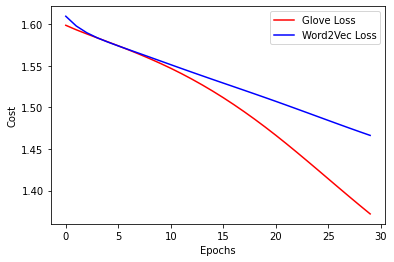

In [72]:
plot(glosses, wlosses)

## Visualization with TSNE

In [75]:
gl=np.array(glosses).reshape(-1, 1)

In [76]:
from yellowbrick.text.tsne import tsne
tsne(gl, labels)

ValueError: ignored

In [ ]:
# thanks to @timothee from deep learning DIY (pca notebook)
def display_mnist(reduced, labels, title):
  """ Displays a colored scatter plot of the reduced labels.
    params : reduced is a numpy array of size N x 2 containing the points to plot
             labels is a numpy array containing the labels
  """
  plt.figure(dpi=150)
  for number_to_plot in range(10):
    to_plot = (labels == number_to_plot)
    plt.scatter(reduced[to_plot, 1], -reduced[to_plot, 0], label=str(number_to_plot))
  plt.legend()
  plt.title(title)
  # plt.scatter(reduced[:, 1], -reduced[:, 0], c=labels)
  plt.show()

In [ ]:
from sklearn.manifold import TSNE
  
transformed = TSNE(n_components=2).fit_transform(w2v_test)
display_mnist(transformed, labels[:500])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: ignored